# Module 4 Project
### Khairul Omar, Stuti Singh & Aleksandar Gavokic

# Executive summary

Insert executive summary here

# 1. Data import

In [1]:
# Import general libraries
import pandas as pd
pd.set_option('display.max_rows', 540)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from textwrap import wrap
import warnings
warnings.filterwarnings('ignore')
# Import modelling libraries
import scipy.stats as stats
from itertools import combinations
from sklearn.preprocessing import StandardScaler, scale, Normalizer, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# Import raw data
raw = pd.read_csv('analytic_data2019.csv', skiprows=[1,2])
display(raw.shape)
display(raw.head())

(3193, 534)

,State FIPS Code,County FIPS Code,5-digit FIPS Code,State Abbreviation,Name,Release Year,County Ranked (Yes=1/No=0),Premature death raw value,Premature death numerator,Premature death denominator,...,Male population 18-44 raw value,Male population 45-64 raw value,Male population 65+ raw value,Total male population raw value,Female population 0-17 raw value,Female population 18-44 raw value,Female population 45-64 raw value,Female population 65+ raw value,Total female population raw value,Population growth raw value
0,1,0,1000,AL,Alabama,2019,NaN,9917.232898,80440.0,13636816.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1001,AL,Autauga County,2019,1.0,8824.057123,815.0,156132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,1003,AL,Baldwin County,2019,1.0,7224.632160,2827.0,576496.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,5,1005,AL,Barbour County,2019,1.0,9586.165037,451.0,72222.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,7,1007,AL,Bibb County,2019,1.0,11783.543675,445.0,63653.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Data Cleansing

In [3]:
# Remove unnecessary columns
filter_out = ['numerator', 'denominator', 'CI low', 'CI high']
df = raw.copy()
for f in filter_out:
    df = df.loc[:, ~df.columns.str.contains(f)]

# Clean up column names
replace_dict = {' raw value':'', ' - ':'_', '-':'_', '=':'', '/':'_',
                '(':'', ')':'', '.':'', '+':' above', '%':'Percent', ' ':'_'}
for key, value in replace_dict.items():
    df.columns = df.columns.str.replace(key, value)

# Drop column if data is > 20% null
df = df.drop(df.loc[:,list((100*(df.isnull().sum()/len(df.index))>20))].columns, 1)

# Replace NaN values with the state's median. If still missing, use national.
df = df.groupby('State_Abbreviation').apply(lambda x: x.fillna(x.median()))
df = df.fillna(df.median())

# # Remove extreme life expenctancy values
# df = df.drop(df[df.Life_expectancy>93].index)

# Remove state-level data, keep only county-level data
df = df.drop(df[df.County_FIPS_Code==0].index)

# Assign a copy of df for graphical purposes
df = df.reset_index(drop=True)
df0 = df.copy()

# Basis of df to use for modelling. Skip columns 0-6 which are non-numerical
df = df.drop(df.iloc[:, 0:7], axis = 1)

cols = list(df.columns)
display(df.shape)

(3142, 74)

# 3. Data Exploration (EDA)

### 3.1 Overview of data via plots

In [4]:
# # Plot all cleansed columns using scatter plot & histogram
# num_of_cols = df.shape[1]
# num_of_plots_per_row = 8
# num_of_sets = num_of_cols // (num_of_plots_per_row + 1)
# k = 0
# for r, s in enumerate(range(num_of_sets)):
#     color = 'blue' if (r % 2) == 0 else 'red'
#     x1 = k
#     x2 = k + num_of_plots_per_row
#     k = k + num_of_plots_per_row + 1
#     r = r * 2
#     dfplot = df.iloc[:, x1:x2]
#     cols_to_plot = list(dfplot.columns)

#     fig, axes = plt.subplots(nrows=2, ncols=len(cols_to_plot), figsize=(18,4))
#     for n, xcol in enumerate(cols_to_plot):
#         axes[0,n].set_title("\n".join(wrap(xcol, 25)), fontsize=9)
#         axes[0,n].scatter(dfplot[xcol], df.Life_expectancy, color=color, s=2)
#         axes[0,n].set_ylabel('Life expectancy', fontsize=8)
#         axes[1,n].hist(dfplot[xcol], color=color)       
#     plt.show()

# 4. Feature Selection (Part 1): Evaluate predictors

### 4.1 Split training and test data

In [5]:
# Split parameters
seed = 1
test_size = 0.31 # to get test sample at least 1000

# Split target and predictors
y_all = df['Life_expectancy']
x_all = df.drop('Life_expectancy', axis=1)

# Split 80/20 for training/testing 
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=test_size, random_state=seed)

# Assign training data
scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_all.columns) # scale training data
y_train = (pd.DataFrame(y_train)).reset_index(drop=True)
dftrain = pd.concat([y_train, x_train], axis=1)

### 4.1 Baseline : calculate k-fold cv with all predictors

In [6]:
# Cross validation using all columns
regression = LinearRegression()
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=seed)
baseline_rsq = np.mean(cross_val_score(regression, x_train, y_train, scoring='r2', cv=crossvalidation))
baseline_mse = -np.mean(cross_val_score(regression, x_train, y_train, cv=5, scoring='neg_mean_squared_error'))
print(f'No of predictors: {x_train.shape[1]}')
print(f'kfold cv r-sq: {round(baseline_rsq,4)}')
print(f'kfold cv MSE : {round(baseline_mse,4)}')

No of predictors: 73
kfold cv r-sq: 0.8909
kfold cv MSE : 1.0496


### 4.2 Evaluate predictors (Step 1) : Correlation of predictors vs. target (Life expectancy)

In [7]:
# Calculate correlation coeff with life expectancy for all predictors
cols = list(dftrain.columns)
corr_list = []

for col in cols:    
    corr = stats.pearsonr(dftrain[col], dftrain.Life_expectancy)    
    corr_list.append([abs(round(corr[0],3)), col])

# Show sorted list of columns and correlations between life expectancy vs. column and log(column)
corr_list = sorted(corr_list, key=lambda i: i[0], reverse=True)
k = 20
print(f'Top {k} Correlation between all predictors vs. Life expectancy:')
display(corr_list[1:k+1])

Top 20 Correlation between all predictors vs. Life expectancy:


[[0.933, 'Premature_age_adjusted_mortality'],
 [0.884, 'Premature_death'],
 [0.699, 'Adult_smoking'],
 [0.691, 'Frequent_mental_distress'],
 [0.669, 'Frequent_physical_distress'],
 [0.664, 'Poor_physical_health_days'],
 [0.655, 'Teen_births'],
 [0.641, 'Children_in_poverty'],
 [0.64, 'Diabetes_prevalence'],
 [0.634, 'Poor_mental_health_days'],
 [0.623, 'Poor_or_fair_health'],
 [0.615, 'Median_household_income'],
 [0.61, 'Physical_inactivity'],
 [0.608, 'Food_insecurity'],
 [0.538, 'Excessive_drinking'],
 [0.534, 'Children_eligible_for_free_or_reduced_price_lunch'],
 [0.532, 'Adult_obesity'],
 [0.532, 'Insufficient_sleep'],
 [0.527, 'Some_college'],
 [0.526, 'Injury_deaths']]

In [8]:
# Top strongest correlation with Life Expectancy, removing the first 3 which are not relevant:
top_n = 15
ignore_from = 3
top_predictors = list(map(lambda x: x[1], corr_list[ignore_from:ignore_from+top_n]))
print(f'Top {top_n} strongest linear correlation with Life Expectancy:')
display(top_predictors)

Top 15 strongest linear correlation with Life Expectancy:


['Adult_smoking',
 'Frequent_mental_distress',
 'Frequent_physical_distress',
 'Poor_physical_health_days',
 'Teen_births',
 'Children_in_poverty',
 'Diabetes_prevalence',
 'Poor_mental_health_days',
 'Poor_or_fair_health',
 'Median_household_income',
 'Physical_inactivity',
 'Food_insecurity',
 'Excessive_drinking',
 'Children_eligible_for_free_or_reduced_price_lunch',
 'Adult_obesity']

### 4.3 Evaluate predictors (Step 2) : Multicollinearity between all predictors

In [9]:
# Check correlation between top columns - to avoid multicollinearity
combo1 = list(combinations(top_predictors, 2))
corr_list1 = []
for comb in combo1:
    corr = stats.pearsonr(dftrain[comb[0]], dftrain[comb[1]])
    corr_list1.append([abs(round(corr[0],3)), comb[0], comb[1]])  
    
# Show sorted list of columns and correlations between life expectancy vs. column and log(column)
corr_list1 = sorted(corr_list1, key=lambda i: i[0], reverse=True)
print('Correlation between predictors to avoid multicollinearity (0.8 cut-off):')
display(list(filter(lambda i: i[0] > 0.8, corr_list1)))

Correlation between predictors to avoid multicollinearity (0.8 cut-off):


[[0.982, 'Frequent_physical_distress', 'Poor_physical_health_days'],
 [0.955, 'Frequent_mental_distress', 'Frequent_physical_distress'],
 [0.954, 'Frequent_mental_distress', 'Poor_physical_health_days'],
 [0.953, 'Frequent_mental_distress', 'Poor_mental_health_days'],
 [0.93, 'Frequent_physical_distress', 'Poor_or_fair_health'],
 [0.918, 'Poor_physical_health_days', 'Poor_mental_health_days'],
 [0.88, 'Poor_physical_health_days', 'Poor_or_fair_health'],
 [0.875, 'Frequent_physical_distress', 'Poor_mental_health_days'],
 [0.844, 'Frequent_mental_distress', 'Poor_or_fair_health'],
 [0.831, 'Children_in_poverty', 'Poor_or_fair_health'],
 [0.824, 'Adult_smoking', 'Frequent_mental_distress'],
 [0.818, 'Adult_smoking', 'Frequent_physical_distress'],
 [0.817, 'Frequent_physical_distress', 'Children_in_poverty'],
 [0.809, 'Adult_smoking', 'Poor_physical_health_days']]

In [10]:
# Drop top predictors based on multicollinearity etc:
drop_list = ['Frequent_mental_distress', 'Frequent_physical_distress', 'Poor_physical_health_days',
             'Children_eligible_for_free_or_reduced_price_lunch']
top_predictors = [i for i in top_predictors if i not in drop_list]
len(top_predictors)

11

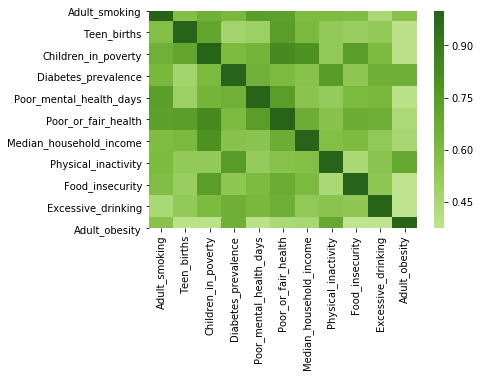

In [11]:
# Validate list via correlation heatmap between top predictors after drop:
sns.heatmap(abs(df[top_predictors[:]].corr()), cmap="PiYG", center=0)
plt.show()

### 4.4 Model 1 : using only top predictors

In [12]:
# Cross validation using top predictors only
x_train = x_train[top_predictors[:]]

regression = LinearRegression()
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=seed)
model1_rsq = np.mean(cross_val_score(regression, x_train, y_train, scoring='r2', cv=crossvalidation))
model1_mse = -np.mean(cross_val_score(regression, x_train, y_train, cv=5, scoring='neg_mean_squared_error'))
print(f'No of predictors: {x_train.shape[1]}')
print(f'kfold cv r-sq: {round(model1_rsq,4)}')
print(f'kfold cv MSE : {round(model1_mse,4)}')

No of predictors: 11
kfold cv r-sq: 0.6608
kfold cv MSE : 3.1236


### 4.5 Evaluate predictors (Step 3) : Interaction between top predictors

In [13]:
# Check interactions between pairs of top predictors
regression = LinearRegression()
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=seed)
combo2 = list(combinations(x_train.columns, 2))
interactions = []
data = pd.DataFrame(scale(x_train), columns=x_train.columns)
for comb in combo2:
    data['interaction'] = data[comb[0]] * data[comb[1]]
    score = np.mean(cross_val_score(regression, data, y_train, scoring='r2', cv=crossvalidation))
    if score > model1_rsq: interactions.append((round(score, 3), comb[0], comb[1]))
interactions = sorted(interactions, key=lambda i: i[0], reverse=True)
k = 20
print(f'Max value of r2: {max(interactions)[0]}')
print(f'Min value of r2: {min(interactions)[0]}')
print(f'Top {k} Interaction cross validation r2 between predictors:')
display(interactions[:k])

Max value of r2: 0.665
Min value of r2: 0.661
Top 20 Interaction cross validation r2 between predictors:


[(0.665, 'Poor_or_fair_health', 'Physical_inactivity'),
 (0.664, 'Adult_smoking', 'Physical_inactivity'),
 (0.664, 'Diabetes_prevalence', 'Poor_mental_health_days'),
 (0.663, 'Children_in_poverty', 'Diabetes_prevalence'),
 (0.663, 'Children_in_poverty', 'Physical_inactivity'),
 (0.663, 'Diabetes_prevalence', 'Poor_or_fair_health'),
 (0.663, 'Diabetes_prevalence', 'Physical_inactivity'),
 (0.663, 'Poor_mental_health_days', 'Physical_inactivity'),
 (0.663, 'Poor_or_fair_health', 'Excessive_drinking'),
 (0.663, 'Median_household_income', 'Physical_inactivity'),
 (0.663, 'Physical_inactivity', 'Adult_obesity'),
 (0.662, 'Adult_smoking', 'Teen_births'),
 (0.662, 'Teen_births', 'Physical_inactivity'),
 (0.662, 'Children_in_poverty', 'Excessive_drinking'),
 (0.662, 'Diabetes_prevalence', 'Median_household_income'),
 (0.662, 'Diabetes_prevalence', 'Excessive_drinking'),
 (0.662, 'Diabetes_prevalence', 'Adult_obesity'),
 (0.662, 'Poor_mental_health_days', 'Excessive_drinking'),
 (0.662, 'Poor_m

### 4.6 Evaluate predictors (Step 4): Polynomial terms

In [14]:
# Explore polynomial terms
degrees = [2, 3]
polynomials = []
for col in x_train.columns:
    for degree in degrees:
        data = x_train.copy()
        poly = PolynomialFeatures(degree, include_bias=False)
        x_transformed = poly.fit_transform(x_train[[col]])
        data = pd.concat([data.drop(col, axis=1),pd.DataFrame(x_transformed)], axis=1)
        score = np.mean(cross_val_score(regression, data, y_train, scoring='r2', cv=crossvalidation))
        polynomials.append((round(score, 3), col, degree))
polynomials = sorted(polynomials, key=lambda i: i[0], reverse=True)
k=20
print(f'Top {k} r2 of polynomial terms for top predictors for degree={degrees}')
display(polynomials[:20])
# Show Top 20:

Top 20 r2 of polynomial terms for top predictors for degree=[2, 3]


[(0.663, 'Diabetes_prevalence', 2),
 (0.663, 'Diabetes_prevalence', 3),
 (0.663, 'Poor_mental_health_days', 3),
 (0.663, 'Physical_inactivity', 2),
 (0.663, 'Physical_inactivity', 3),
 (0.663, 'Adult_obesity', 2),
 (0.663, 'Adult_obesity', 3),
 (0.662, 'Adult_smoking', 3),
 (0.662, 'Poor_or_fair_health', 2),
 (0.662, 'Poor_or_fair_health', 3),
 (0.662, 'Excessive_drinking', 3),
 (0.661, 'Adult_smoking', 2),
 (0.661, 'Teen_births', 2),
 (0.661, 'Poor_mental_health_days', 2),
 (0.661, 'Median_household_income', 2),
 (0.661, 'Food_insecurity', 2),
 (0.661, 'Food_insecurity', 3),
 (0.661, 'Excessive_drinking', 2),
 (0.66, 'Teen_births', 3),
 (0.66, 'Children_in_poverty', 2)]

### 4.7 Add top interaction terms and top polynomial terms into data frame

In [15]:
# Polynomial terms: select columns with highest cv r2
poly_columns = ['Adult_obesity', 'Diabetes_prevalence', 'Physical_inactivity']

# Interaction terms: select pairs of columns with highest cv r2
inter_columns = [['Adult_smoking', 'Adult_obesity'],['Physical_inactivity', 'Adult_obesity']]

# Build new df with Polynomial terms
dfpoly = pd.DataFrame()
for col in poly_columns:
    poly = PolynomialFeatures(3, include_bias=False)
    x_transformed = poly.fit_transform(x_train[[col]])
    colnames= [col, col + '_' + 'power2',  col + '_' + 'power3']
    dfpoly = (pd.concat([dfpoly, pd.DataFrame(x_transformed, columns=colnames)], axis=1)).drop([col], axis=1)

# Build new df with Interaction terms
dfinter = pd.DataFrame()
for col in inter_columns:
    colname = f'{col[0]}_AND_{col[1]}'
    dfinter[colname] = x_train[col[0]] * x_train[col[1]]
    
# Merge with all predictors
df_shortlist = pd.concat([y_train, x_train, dfpoly, dfinter], axis=1)
x_shortlist = df_shortlist.drop('Life_expectancy', axis=1)
x_shortlist.columns

Index(['Adult_smoking', 'Teen_births', 'Children_in_poverty',
       'Diabetes_prevalence', 'Poor_mental_health_days', 'Poor_or_fair_health',
       'Median_household_income', 'Physical_inactivity', 'Food_insecurity',
       'Excessive_drinking', 'Adult_obesity', 'Adult_obesity_power2',
       'Adult_obesity_power3', 'Diabetes_prevalence_power2',
       'Diabetes_prevalence_power3', 'Physical_inactivity_power2',
       'Physical_inactivity_power3', 'Adult_smoking_AND_Adult_obesity',
       'Physical_inactivity_AND_Adult_obesity'],
      dtype='object')

# 5. Feature selection (Part 2) : finalize predictors

### 5.1 Model 2 : use top predictors + top interactions + top polynomial terms

In [16]:
# Calculate new baseline with shortlisted columns, interactions and polynomial terms
x_train = x_shortlist
regression = LinearRegression()
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=seed)
model2_rsq = np.mean(cross_val_score(regression, x_train, y_train, scoring='r2', cv=crossvalidation))
model2_mse = -np.mean(cross_val_score(regression, x_train, y_train, cv=5, scoring='neg_mean_squared_error'))
print(f'No of predictors: {x_train.shape[1]}')
print(f'kfold cv r-sq: {round(model2_rsq,4)}')
print(f'kfold cv MSE : {round(model2_mse,4)}')

No of predictors: 19
kfold cv r-sq: 0.6631
kfold cv MSE : 3.0891


### 5.2 Determine strongest predictor terms (based on correlation)

In [17]:
# Calculate correlation coeff with Life Expectancy:
cols = list(df_shortlist.iloc[:, 1:].columns) # skip Life expectancy
corr_list = []
top_predictors = []

for col in cols:    
    # Correlation with x    
    corr = stats.pearsonr(df_shortlist[col], df_shortlist.Life_expectancy)    
    # Correlation with log x
    transformer = Normalizer().fit([df_shortlist[col]])
    t = transformer.transform([df_shortlist[col]])   
    if df_shortlist[col].min() <= 0:
        corrlog = 0
    else:
        corrlog = stats.pearsonr(np.log(t[0]), df_shortlist.Life_expectancy)[0]
    # Output list
    corr_list.append([abs(round(corr[0],3)), col])
    top_predictors.append(col)

# Show sorted list of columns and correlations between life expectancy vs. column and log(column)
corr_list = sorted(corr_list, key=lambda i: i[0], reverse=True)
print(f'Sorted correlation between all predictors vs. Life expectancy:')
display(corr_list[:])

Sorted correlation between all predictors vs. Life expectancy:


[[0.704, 'Adult_smoking_AND_Adult_obesity'],
 [0.699, 'Adult_smoking'],
 [0.655, 'Teen_births'],
 [0.641, 'Children_in_poverty'],
 [0.64, 'Diabetes_prevalence'],
 [0.634, 'Poor_mental_health_days'],
 [0.623, 'Poor_or_fair_health'],
 [0.62, 'Physical_inactivity_AND_Adult_obesity'],
 [0.616, 'Diabetes_prevalence_power2'],
 [0.615, 'Median_household_income'],
 [0.61, 'Physical_inactivity'],
 [0.608, 'Food_insecurity'],
 [0.588, 'Physical_inactivity_power2'],
 [0.573, 'Diabetes_prevalence_power3'],
 [0.549, 'Physical_inactivity_power3'],
 [0.538, 'Excessive_drinking'],
 [0.532, 'Adult_obesity'],
 [0.522, 'Adult_obesity_power2'],
 [0.502, 'Adult_obesity_power3']]

### 5.3 Determine strongest predictor terms (based on standardized coefficient)

In [18]:
# Calculate coefficients
linreg = LinearRegression()
linreg.fit(x_train, y_train)
coeff = linreg.coef_
coeff_list = []
for n, col in enumerate(cols):
    coeff_list.append([abs(round(coeff[0][n],3)), 'Negative' if coeff[0][n] < 0 else 'Positive', col])
coeff_list = sorted(coeff_list, key=lambda i: i[0], reverse=True)
coeff_list

[[32.808, 'Positive', 'Adult_obesity_power2'],
 [18.414, 'Negative', 'Adult_obesity_power3'],
 [16.182, 'Negative', 'Adult_obesity'],
 [7.723, 'Negative', 'Teen_births'],
 [5.693, 'Positive', 'Poor_or_fair_health'],
 [4.914, 'Positive', 'Physical_inactivity_power2'],
 [4.813, 'Negative', 'Adult_smoking'],
 [4.543, 'Negative', 'Adult_smoking_AND_Adult_obesity'],
 [4.288, 'Negative', 'Physical_inactivity_AND_Adult_obesity'],
 [4.285, 'Negative', 'Food_insecurity'],
 [3.832, 'Negative', 'Physical_inactivity'],
 [3.125, 'Negative', 'Poor_mental_health_days'],
 [2.968, 'Negative', 'Diabetes_prevalence'],
 [1.72, 'Positive', 'Diabetes_prevalence_power3'],
 [1.419, 'Positive', 'Median_household_income'],
 [0.734, 'Positive', 'Excessive_drinking'],
 [0.376, 'Negative', 'Children_in_poverty'],
 [0.347, 'Negative', 'Physical_inactivity_power3'],
 [0.154, 'Negative', 'Diabetes_prevalence_power2']]

# 6. Final model

### 6.1 Prepare training and test data

In [19]:
# Assign training data to the final choice of predictors
x_train = x_shortlist

# Assign test data (before processing)
x_test_raw = pd.DataFrame(x_test, columns=x_all.columns)

# Test data still has the same number of original columns.
# Now reshape test data columns to match the final set of columns in train data:
final_columns = list(x_train.columns)
df_test = pd.DataFrame()
for col in final_columns:
    # Create interaction terms
    if col.find('_AND_') != -1:
        c = 1
        inter1 = col[0:col.find('_AND_')]
        inter2 = col[(-1)*(len(col)-5-len(inter1)):]
        c = [inter1,inter2]
        df_test[f'{inter1}_AND_{inter2}'] = x_test_raw[inter1] * x_test_raw[inter2]
    # Create polynomial terms
    elif col.find('_power') != -1:
        polycol = col[:len(col)-7]
        power = int(col[-1:])
        c = [polycol, power]
        df_test[f'{polycol}_power{power}'] = x_test_raw[polycol]      
    # Original terms
    else:
        c = col
        df_test[col] = x_test_raw[col]

# Assign test data (after processing)
scaler = MinMaxScaler()
x_test = pd.DataFrame(scaler.fit_transform(df_test), columns=df_test.columns) # scale training data
y_test = (pd.DataFrame(y_test)).reset_index(drop=True)

# Double check data dimensions are the comparable
print(f'x_train:{x_train.shape}, y_train:{y_train.shape}, x_test:{x_test.shape}, y_test:{y_test.shape}')

x_train:(2167, 19), y_train:(2167, 1), x_test:(975, 19), y_test:(975, 1)


### 6.2 Run final model with training and test data

In [20]:
# Run model with training and test data

linreg = LinearRegression()
linreg.fit(x_train, y_train)

pred_train = linreg.predict(x_train)
pred_test  = linreg.predict(x_test)

final_train_rsq = linreg.score(x_train, y_train)
final_test_rsq  = linreg.score(x_test, y_test)
final_train_mse = mean_squared_error(y_train, pred_train)
final_test_mse  = mean_squared_error(y_test, pred_test)

print('Summary of r^2 improvements')
print('---------------------------')
print('1. Overfit using all predictors  :', round(baseline_rsq,4))
print('2. Model 1 using strongest corr  :', round(model1_rsq,4))
print('3. Model 2 incl poly & interacts :', round(model2_rsq,4))
print('4. Model 3 (final) with Train set:', round(final_train_rsq,4))
print('5. Model 3 (final) with Test set :', round(final_test_rsq,4))
print('')
print('Summary of MSE improvements')
print('---------------------------')
print('1. Overfit using all predictors  :', round(baseline_mse,4))
print('2. Model 1 using strongest corr  :', round(model1_mse,4))
print('3. Model 2 incl poly & interacts :', round(model2_mse,4))
print('4. Model 3 (final) with Train set:', round(final_train_mse,4))
print('5. Model 3 (final) with Test set :', round(final_test_mse,4))

Summary of r^2 improvements
---------------------------
1. Overfit using all predictors  : 0.8909
2. Model 1 using strongest corr  : 0.6608
3. Model 2 incl poly & interacts : 0.6631
4. Model 3 (final) with Train set: 0.6715
5. Model 3 (final) with Test set : 0.5051

Summary of MSE improvements
---------------------------
1. Overfit using all predictors  : 1.0496
2. Model 1 using strongest corr  : 3.1236
3. Model 2 incl poly & interacts : 3.0891
4. Model 3 (final) with Train set: 2.9984
5. Model 3 (final) with Test set : 4.1015


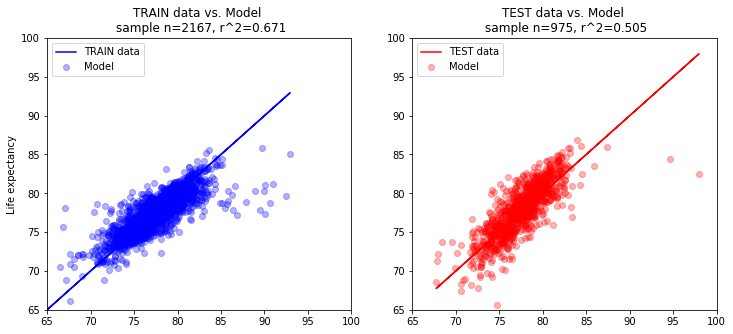

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
axes[0].scatter(y_train, pred_train, label='Model', color='blue', alpha=0.3)
axes[0].plot(y_train, y_train, label='TRAIN data', color='blue')
axes[1].scatter(y_test, pred_test, label='Model', color='red', alpha=0.3)
axes[1].plot(y_test, y_test, label='TEST data', color='red')
axes[0].set_xlim(65,100)
axes[0].set_ylim(65,100)
axes[1].set_xlim(65,100)
axes[1].set_ylim(65,100)
axes[0].set_ylabel('Life expectancy')
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[0].set_title(f'TRAIN data vs. Model \n sample n={x_train.shape[0]}, r^2={round(final_train_rsq,3)}')
axes[1].set_title(f'TEST data vs. Model \n sample n={x_test.shape[0]}, r^2={round(final_test_rsq,3)}')
plt.legend()
plt.show()

### 6.3 Employ regularization techniques using Ridge and Lasso

Optimal Alpha Value: 0


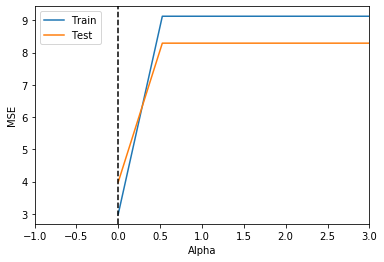

In [22]:
# Find optimum alpha
train_mse = []
test_mse = []
alphas = []
for alpha in np.linspace(0, 10, num=20):
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_train, y_train)
    train_preds = lasso.predict(x_train)
    train_mse.append(mean_squared_error(y_train, train_preds))
    test_preds = lasso.predict(x_test)
    test_mse.append(mean_squared_error(y_test, test_preds))
    alphas.append(alpha)
    
# Plot optimal value
fig, ax = plt.subplots()
ax.plot(alphas, train_mse, label='Train')
ax.plot(alphas, test_mse, label='Test')
ax.set_xlabel('Alpha')
ax.set_ylabel('MSE')
ax.set_xlim(-1,3)

# Generate optimum alpha
optimal_alpha = alphas[np.argmin(test_mse)]
ax.axvline(optimal_alpha, color='black', linestyle='--')
ax.legend();
print(f'Optimal Alpha Value: {int(optimal_alpha)}')

In [23]:
# Set penalty factors
alpha_lasso = 0.1
alpha_ridge = 1

# Run Ridge and Lasso on train data
lasso = Lasso(alpha_lasso)
lasso.fit(x_train, y_train)
print(f'-----Lasso alpha={alpha_lasso}-----')
display(lasso.coef_)

ridge = Ridge(alpha_ridge)
ridge.fit(x_train, y_train)
print(f'------Ridge alpha={alpha_ridge}------')
display(ridge.coef_)

-----Lasso alpha=0.1-----


array([-0.        , -4.48370371, -0.        , -1.94726375, -3.90385406,
       -0.        ,  0.        , -1.67692604, -0.45913004,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ])

------Ridge alpha=1------


array([[-4.93492837, -7.09579272, -0.47475012, -3.00362727, -2.92344204,
         4.56852111,  1.52209605, -3.13494634, -4.10531236,  0.60978858,
        -2.37295786,  0.87442044,  0.90748249,  0.04348588,  1.38198496,
         0.3678175 ,  1.48090244, -2.92194386,  0.05533758]])

In [24]:
# Calculate AIC BIC

# 7. Conclusion

Text here